# Wild Fire Model Evaluation

This notebooks will evaluate severals model on the wildfire dataset in order to make a predecction on fire intensity and CO2 emissions. A down selection will be made to 2-3 models for further hyper-paramater tuning. 

#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

In [6]:
#optional code to ensure everyone is on the right version
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.3.


# Import all the models we will likely use for classificaiton

In [7]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

from yellowbrick.classifier import ClassificationReport



# Helper function to save estimator
Saves to current working directory

In [8]:
def save_estimator (estimator) :
          
    outpath = estimator.__class__.__name__.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)
        f.close()
        
    #print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [9]:
def open_estimator(filename) :
    
    infile = open(filename,'rb')
    estimator = pickle.load(infile)
    infile.close()

    print ("Unpickled file", filename)
    
    return estimator

# Read the Fire Data From Disk to Save Time.
During the feature evaluation the data was pulled from the database and stored locally

#This helper function allows for a random sample instead of reading everything

import random

def read_random_sample(sample_size, file_name):


    total_records = 1328922 #number of records in file
    skip = sorted(random.sample(range(total_records), total_records-sample_size))
    
    #don't skip the header line of the file
    if (skip[0] == 0):
        skip[0] = 2

        
    df = pd.read_csv(file_name, skiprows=skip)
  
    ''' #check to see numbers are being skipped - will only notice if a larger number of files is chosen
    for i in skip: 
        print (skip[i], end =" ") 
        if i == 1000:
            return
    '''
    
    return df


In [32]:
#Read the data from disk for faster access

df_fires = pd.read_csv('data/FireIntensity_Model_June7_Clean.csv')

#get a sample of the data to save time - comment out if you want all the data
#     df_fires = read_random_sample(50000, 'data/FireIntensity_Model_June7_Clean.csv')

#use this line to get all the data
#df_fires = pd.read_csv('data/FireIntensity_Model_June7_Clean.csv')



In [33]:
# Random Sample of DF to reduce size:

#df_fires = df_fires.sample(frac=0.25, replace=True, random_state=1)

# Assess shape and data in the file. 
Check data to ensure it's correct.


In [34]:
# Expanding number of columns:
pd.set_option('display.max_columns', 40)

In [35]:
# review datagram
print (df_fires.shape)
df_fires.head(3)

(1328922, 22)


,latitude,longitude,doy,month,year,cluster_reference,fire_region,season,covertype,fuelcode,prefire_fuel,fuel_moisture_class,temperature,humidity,precip_intensity,visibility,wind_speed,wind_gust,brightness,fire_intensity,bright_t31,frp
0,34.59540,-78.62180,1,1,2003,2003_4279,6,3,3,1600,6220.09758,3,64.14000,0.88000,0.01100,9.02200,6.42000,12.51000,306.50000,Low,289.20000,11.00000
1,33.41820,-110.86180,1,1,2003,2003_1522,4,3,3,1220,4534.18726,2,32.17000,0.37000,0.00000,9.21629,6.88000,18.50000,307.60000,Low,285.10000,10.80000
2,29.71200,-95.12840,1,1,2003,2003_919,3,3,1,1,277.41285,2,65.97000,0.50000,0.00000,9.99700,10.98000,16.90000,307.20000,Low,294.10000,5.60000


In [36]:
df_fires = df_fires.drop(columns={'latitude', 'longitude','cluster_reference', 'doy', 'month', 'year', 'brightness', 'bright_t31','frp'})

In [37]:
df_fires.head(2)

,fire_region,season,covertype,fuelcode,prefire_fuel,fuel_moisture_class,temperature,humidity,precip_intensity,visibility,wind_speed,wind_gust,fire_intensity
0,6,3,3,1600,6220.09758,3,64.14000,0.88000,0.01100,9.02200,6.42000,12.51000,Low
1,4,3,3,1220,4534.18726,2,32.17000,0.37000,0.00000,9.21629,6.88000,18.50000,Low


In [38]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [39]:
#show the shape of the data

print (df_fires.shape)
print (df_fires.describe())
df_fires.head(3)

(1328922, 13)
        fire_region        season     covertype      fuelcode  prefire_fuel  \
count 1328922.00000 1328922.00000 1328922.00000 1328922.00000 1328922.00000   
mean        2.74274       1.33294       2.34710     830.22111    3854.21233   
std         2.11958       1.04687       0.87929     709.32156    3008.37354   
min         0.00000       0.00000       1.00000       1.00000      19.61505   
25%         1.00000       0.00000       1.00000       1.00000     320.67805   
50%         2.00000       1.00000       3.00000    1160.00000    4335.06854   
75%         4.00000       2.00000       3.00000    1280.00000    6989.97325   
max         7.00000       3.00000       3.00000    2950.00000   13337.51083   

       fuel_moisture_class   temperature      humidity  precip_intensity  \
count        1328922.00000 1328922.00000 1328922.00000     1328922.00000   
mean               2.26137      69.96215       0.41110           0.00269   
std                0.70759      14.98959      

,fire_region,season,covertype,fuelcode,prefire_fuel,fuel_moisture_class,temperature,humidity,precip_intensity,visibility,wind_speed,wind_gust,fire_intensity
0,6,3,3,1600,6220.09758,3,64.14000,0.88000,0.01100,9.02200,6.42000,12.51000,Low
1,4,3,3,1220,4534.18726,2,32.17000,0.37000,0.00000,9.21629,6.88000,18.50000,Low
2,3,3,1,1,277.41285,2,65.97000,0.50000,0.00000,9.99700,10.98000,16.90000,Low


# Setting Up Features:

In [40]:
features = ['fire_region', 'season', 'covertype', 'fuelcode', 'fuel_moisture_class', 'prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 'visibility', 'wind_gust', 'wind_speed']

cat_features = ['fire_region', 'season', 'covertype', 'fuelcode', 'fuel_moisture_class']

num_features = ['prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 'visibility', 'wind_gust', 'wind_speed']

target = ['fire_intensity']

y = df_fires[target]
y = np.ravel(y)
X = df_fires[features]

#encode_columns = ('fire_region', 'season', 'covertype', 'fuel_moisture_class')
#onehot_list = df_fires[encode_columns]

## Pipeline to Transform:

In [41]:
# Processing y.
y = LabelEncoder().fit_transform(y) # Label-encode targets before modeling

In [42]:
# Processing X Features. 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),

numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler(feature_range=(0, 1), copy=True))])
#numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    #('imputer', SimpleImputer(strategy='median')),


In [43]:
# Setting the transformation for the pipeline below. 
preprocessor = ColumnTransformer (transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])


#column_trans = make_column_transformer((OneHotEncoder(), ['fire_region', 'season',
 #                               'fuelcode', 'fuel_moisture_class']),
  #                               remainder='passthrough')
    
column_trans.fit_transform(X)
y = LabelEncoder().fit_transform(y)


# Define the models to test
<b>Commented out slower performing models and limited the interations/estimators for speed</b>

In [45]:
'''
    models = [
        SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(), 
        SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
        LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
        BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
        RandomForestClassifier(n_estimators=100),
        ]    
'''
models = [MultinomialNB(), AdaBoostClassifier()]
#models = [AdaBoostClassifier()]

# Function to Fit and predict the scores of the model. 
Helps in the initial down selection

In [46]:
def score_model(X, y, estimator, **kwargs):
    
    """
    Test various estimators.
   
    #y = LabelEncoder().fit_transform(y)

   
    
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder(categories = 'auto')), 
         ('estimator', estimator)
    ])
    """ 
    
    #model = Pipeline([
#         ('trans', column_trans), 
 #        ('estimator', estimator)
  #  ])
   
    model = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('estimator', estimator)
      ])
    
    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected = y
    predicted = model.predict(X)
    
   
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='macro')))
   
    return save_estimator(estimator)
    
    


# Iterate through the different models

In [47]:
for model in models:
    score_model(X, y, model)

MultinomialNB: 0.37180116283889897
AdaBoostClassifier: 0.42931362645526794


# Function to visualize the model out using yellow brick classification report.
<b> Error is thrown here using the LabelEncoder and one_hot_encoder <b/>

In [48]:
def visualize_model(X, y, estimator):
    
    """
    Test various estimators.
    
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder(categories='auto')), 
         ('estimator', estimator)
    ])
    """ 
    
   # model = Pipeline([
    #     ('trans', column_trans), 
     #    ('estimator', estimator)
    #])
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('estimator', estimator)
    ])
   
   
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['Low', 'Medium', 'High', 'Severe'], 
        cmap="Reds", 
        support=True,
        size=(800, 660)
    )
    
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    
    
    visualizer.fit(X_train, y_train)  
    
    
    visualizer.score(X_test, y_test)
    
    #optional
    #visualizer.show(outpath=estimator.__class__.__name__ + ".png")  
    
    visualizer.show()
 

    

# Iterate through the models to visualize

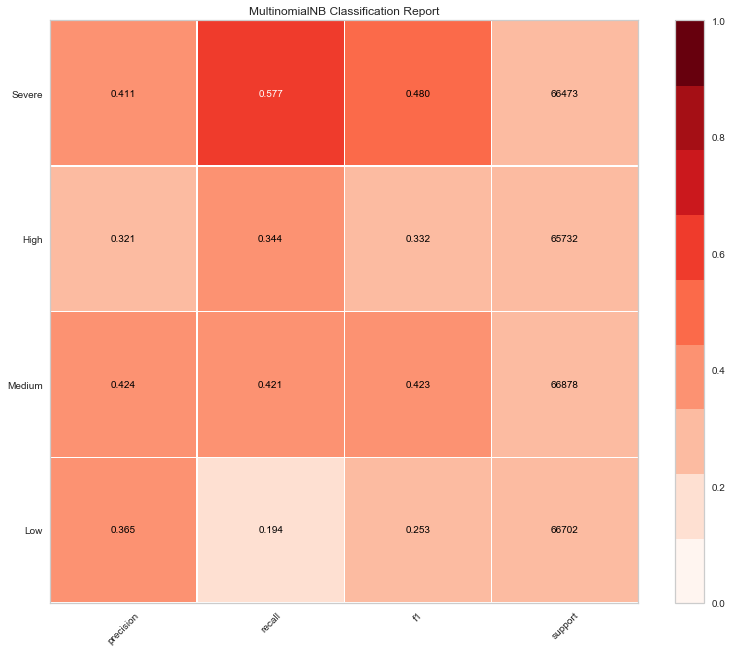

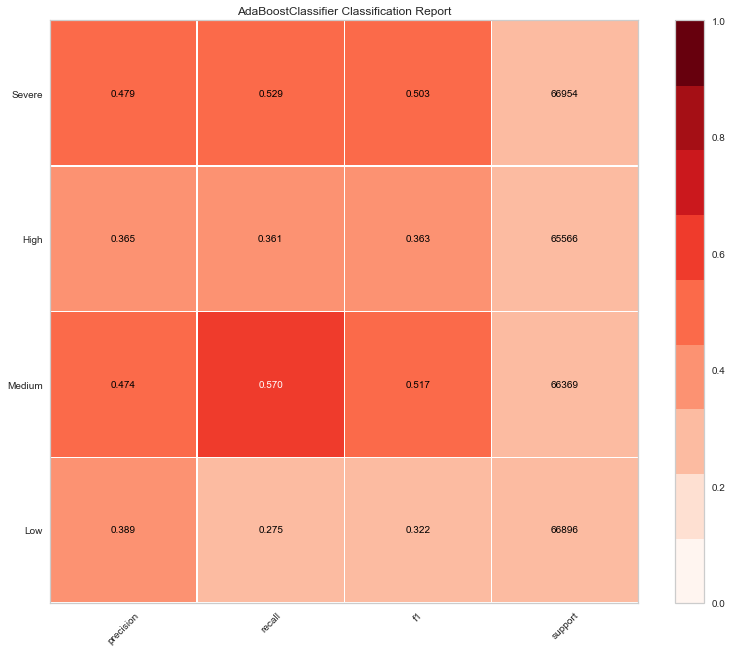

In [49]:
for model in models:
    visualize_model(X, y, model)
    